In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
import scipy.io as sio
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
# import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def preprocess(wav):
    wav = sklearn.preprocessing.maxabs_scale(wav)
    wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
    wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
    wav_mfcc_std_mean = wav_mfcc_std.mean(axis=1)

    features = np.concatenate([wav_mfcc_std_mean])
    return features

In [10]:
def build_batchnorm_cnn(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv1D(kernel_size=25, filters=8, strides=1, padding='valid', 
                  activation='relu', input_shape=input_shape))  
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=8*(2**(i+1)), strides=1, padding='valid', 
                          activation='relu'))  
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense( 1024/(2**i), activation='relu' ))
        model.add(Dropout(0.5))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

In [11]:
# model = build_cnn(conv_num=3, fcn_num=1)
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.6136 - acc: 0.3200
Epoch 00001: val_loss improved from inf to 1.62301, saving model to model/checkpoint/1D_CNN_BN_1_conv_1_fcn_checkpoint/01-1.6230.hdf5
36805/36805 [==============================] - 18s 492us/sample - loss: 2.6121 - acc: 0.3203 - val_loss: 1.6230 - val_acc: 0.5369
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.3706 - acc: 0.5910
Epoch 00002: val_loss improved from 1.62301 to 1.14824, saving model to model/checkpoint/1D_CNN_BN_1_conv_1_fcn_checkpoint/02-1.1482.hdf5
36805/36805 [==============================] - 17s 451us/sample - loss: 1.3706 - acc: 0.5909 - val_loss: 1.1482 - val_acc:

Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0808 - acc: 0.9799
Epoch 00026: val_loss did not improve from 0.98817
36805/36805 [==============================] - 16s 441us/sample - loss: 0.0807 - acc: 0.9799 - val_loss: 1.3630 - val_acc: 0.7352
Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0826 - acc: 0.9781
Epoch 00027: val_loss did not improve from 0.98817
36805/36805 [==============================] - 16s 444us/sample - loss: 0.0826 - acc: 0.9781 - val_loss: 1.4243 - val_acc: 0.7349
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0664 - acc: 0.9833
Epoch 00028: val_loss did not improve from 0.98817
36805/36805 [==============================] - 17s 451us/sample - loss: 0.0664 - acc: 0.9833 - val_loss: 1.3494 - val_acc: 0.7310
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0782 - acc: 0.9815
Epoch 00029: val_loss did not improve from 0.98817
36805/36805 [=====

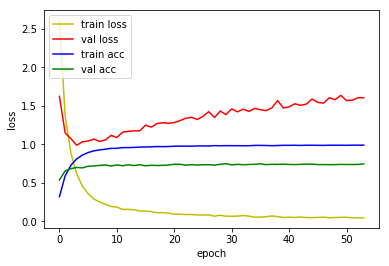

4815/4815 [==============================] - 1s 289us/sample - loss: 1.1910 - acc: 0.6540
Loss: 1.1909752211466758 Accuracy: 0.6539979

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.9418 - acc: 0.1783
Epoch 00001: val_loss improved from inf to 2.22166, saving model to model/checkpoint/1D_CNN_BN_1_conv_2_fcn_checkpoint/01-2.2217.hdf5
36805/36805 [==============================] - 19s 508us/sample - loss: 2.9417 - acc: 0.1782 - val_loss: 2.2217 - val_acc: 0.3652
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.0806 - acc: 0.3420
Epoch 00002: val_loss improved from 2.22166 to 1.64008, saving model to model/checkpoint/1D_CNN_BN_1_conv_2_fcn_checkpoint/02-1.6401.hdf5
36805/36805 [==============================] - 17s 466us/sample - loss: 2.0806 - acc: 0.3420 - val_loss: 1.6401 - val_acc: 0.5017
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.7248 - acc: 0.

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1266 - acc: 0.9611
Epoch 00027: val_loss did not improve from 0.86963
36805/36805 [==============================] - 17s 451us/sample - loss: 0.1268 - acc: 0.9611 - val_loss: 1.1070 - val_acc: 0.7293
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1327 - acc: 0.9588
Epoch 00028: val_loss did not improve from 0.86963
36805/36805 [==============================] - 16s 439us/sample - loss: 0.1327 - acc: 0.9588 - val_loss: 1.1198 - val_acc: 0.7400
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1247 - acc: 0.9633
Epoch 00029: val_loss did not improve from 0.86963
36805/36805 [==============================] - 16s 441us/sample - loss: 0.1247 - acc: 0.9633 - val_loss: 1.1467 - val_acc: 0.7310
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1162 - acc: 0.9651
Epoch 00030: val_loss did not improve from 0.86963
36805/36805 [=====

Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9831
Epoch 00057: val_loss did not improve from 0.86963
36805/36805 [==============================] - 16s 423us/sample - loss: 0.0578 - acc: 0.9831 - val_loss: 1.4140 - val_acc: 0.7417
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0658 - acc: 0.9822
Epoch 00058: val_loss did not improve from 0.86963
36805/36805 [==============================] - 16s 426us/sample - loss: 0.0658 - acc: 0.9822 - val_loss: 1.4140 - val_acc: 0.7435
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0587 - acc: 0.9837
Epoch 00059: val_loss did not improve from 0.86963
36805/36805 [==============================] - 16s 428us/sample - loss: 0.0587 - acc: 0.9837 - val_loss: 1.3946 - val_acc: 0.7310
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0615 - acc: 0.9823
Epoch 00060: val_loss did not improve from 0.86963
36805/36805 [=====

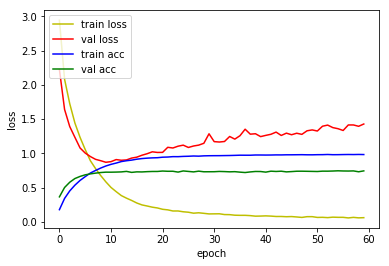

4815/4815 [==============================] - 1s 204us/sample - loss: 1.0075 - acc: 0.6800
Loss: 1.007487106595579 Accuracy: 0.67995846

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.2625 - acc: 0.3791
Epoch 00001: val_loss improved from inf to 1.86356, saving model to model/checkpoint/1D_CNN_BN_2_conv_1_fcn_checkpoint/01-1.8636.hdf5
36805/36805 [==============================] - 17s 464us/sample - loss: 2.2609 - acc: 0.3795 - val_loss: 1.8636 - val_acc: 0.4598
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.0887 - acc: 0.6572
Epoch 00002: val_loss improved from 1.86356 to 0.85986, saving model to model/checkpoint/1D_CNN_BN_2_conv_1_fcn_checkpoint/02-0.8599.hdf5
36805/36805 [==============================] - 15s 414us/sample - loss: 1.0887 - acc: 0.6573 - val_loss: 0.8599 - val_acc: 0.7356
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.6893 - acc: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9924
Epoch 00028: val_loss did not improve from 0.62654
36805/36805 [==============================] - 15s 398us/sample - loss: 0.0264 - acc: 0.9924 - val_loss: 0.9479 - val_acc: 0.8269
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9913
Epoch 00029: val_loss did not improve from 0.62654
36805/36805 [==============================] - 15s 398us/sample - loss: 0.0285 - acc: 0.9914 - val_loss: 0.9125 - val_acc: 0.8311
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9924
Epoch 00030: val_loss did not improve from 0.62654
36805/36805 [==============================] - 15s 399us/sample - loss: 0.0255 - acc: 0.9924 - val_loss: 0.8131 - val_acc: 0.8260
Epoch 31/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9930
Epoch 00031: val_loss did not improve from 0.62654
36805/36805 [==================

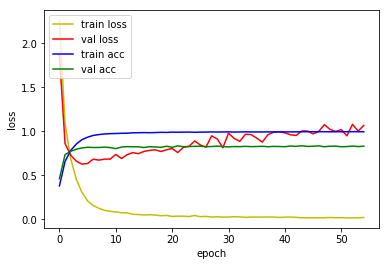

4815/4815 [==============================] - 1s 222us/sample - loss: 0.7222 - acc: 0.7745
Loss: 0.722207755128914 Accuracy: 0.77445483

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.6774 - acc: 0.2369
Epoch 00001: val_loss improved from inf to 1.93436, saving model to model/checkpoint/1D_CNN_BN_2_conv_2_fcn_checkpoint/01-1.9344.hdf5
36805/36805 [==============================] - 18s 501us/sample - loss: 2.6760 - acc: 0.2371 - val_loss: 1.9344 - val_acc: 0.3739
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.7671 - acc: 0.4349
Epoch 00002: val_loss improved from 1.93436 to 1.25297, saving model to model/checkpoint/1D_CNN_BN_2_conv_2_fcn_checkpoint/02-1.2530.hdf5
36805/36805 [==============================] - 15s 413us/sample - loss: 1.7671 - acc: 0.4349 - val_loss: 1.2530 - val_acc: 0.6096
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.3785 - acc: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0831 - acc: 0.9751
Epoch 00027: val_loss did not improve from 0.63457
36805/36805 [==============================] - 15s 405us/sample - loss: 0.0831 - acc: 0.9751 - val_loss: 0.8134 - val_acc: 0.8167
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0678 - acc: 0.9797
Epoch 00028: val_loss did not improve from 0.63457
36805/36805 [==============================] - 15s 409us/sample - loss: 0.0679 - acc: 0.9796 - val_loss: 0.7452 - val_acc: 0.8113
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0660 - acc: 0.9807
Epoch 00029: val_loss did not improve from 0.63457
36805/36805 [==============================] - 15s 404us/sample - loss: 0.0659 - acc: 0.9807 - val_loss: 0.7775 - val_acc: 0.8164
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0664 - acc: 0.9811
Epoch 00030: val_loss did not improve from 0.63457
36805/36805 [==================

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9891
Epoch 00057: val_loss did not improve from 0.63457
36805/36805 [==============================] - 15s 402us/sample - loss: 0.0390 - acc: 0.9891 - val_loss: 1.0154 - val_acc: 0.8167
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9893
Epoch 00058: val_loss did not improve from 0.63457
36805/36805 [==============================] - 15s 400us/sample - loss: 0.0369 - acc: 0.9893 - val_loss: 0.9521 - val_acc: 0.8146
Epoch 59/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9896
Epoch 00059: val_loss did not improve from 0.63457
36805/36805 [==============================] - 15s 398us/sample - loss: 0.0378 - acc: 0.9896 - val_loss: 0.9788 - val_acc: 0.8078
Epoch 60/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9903
Epoch 00060: val_loss did not improve from 0.63457
36805/36805 [=====

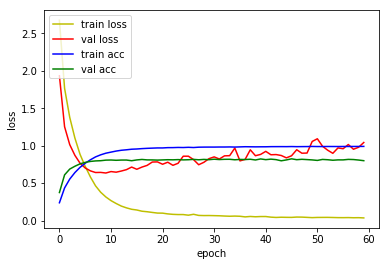

4815/4815 [==============================] - 1s 250us/sample - loss: 0.7919 - acc: 0.7666
Loss: 0.7918561905962903 Accuracy: 0.7665628

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.9096 - acc: 0.4651
Epoch 00001: val_loss improved from inf to 3.22835, saving model to model/checkpoint/1D_CNN_BN_3_conv_1_fcn_checkpoint/01-3.2284.hdf5
36805/36805 [==============================] - 19s 509us/sample - loss: 1.9077 - acc: 0.4655 - val_loss: 3.2284 - val_acc: 0.3173
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9682 - acc: 0.6965
Epoch 00002: val_loss improved from 3.22835 to 0.65656, saving model to model/checkpoint/1D_CNN_BN_3_conv_1_fcn_checkpoint/02-0.6566.hdf5
36805/36805 [==============================] - 15s 409us/sample - loss: 0.9682 - acc: 0.6965 - val_loss: 0.6566 - val_acc: 0.7913
Epoch 3/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.6877 - acc: 0.

Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9915
Epoch 00028: val_loss did not improve from 0.39640
36805/36805 [==============================] - 15s 407us/sample - loss: 0.0266 - acc: 0.9915 - val_loss: 0.5114 - val_acc: 0.8814
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9916
Epoch 00029: val_loss did not improve from 0.39640
36805/36805 [==============================] - 15s 408us/sample - loss: 0.0237 - acc: 0.9916 - val_loss: 0.4937 - val_acc: 0.8838
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9929
Epoch 00030: val_loss did not improve from 0.39640
36805/36805 [==============================] - 15s 409us/sample - loss: 0.0234 - acc: 0.9928 - val_loss: 0.5010 - val_acc: 0.8842
Epoch 31/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9907
Epoch 00031: val_loss did not improve from 0.39640
36805/36805 [=====

Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9955
Epoch 00058: val_loss did not improve from 0.39640
36805/36805 [==============================] - 15s 418us/sample - loss: 0.0136 - acc: 0.9955 - val_loss: 0.6770 - val_acc: 0.8765

3 Conv 1 FCN Model


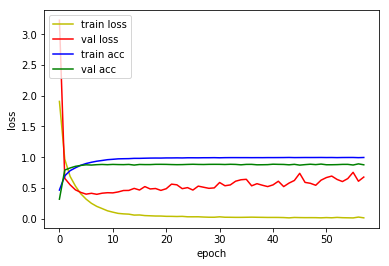

4815/4815 [==============================] - 1s 291us/sample - loss: 0.5191 - acc: 0.8461
Loss: 0.5190651477682999 Accuracy: 0.84610593

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.5784 - acc: 0.2587
Epoch 00001: val_loss improved from inf to 2.56765, saving model to model/checkpoint/1D_CNN_BN_3_conv_2_fcn_checkpoint/01-2.5676.hdf5
36805/36805 [==============================] - 21s 573us/sample - loss: 2.5783 - acc: 0.2587 - val_loss: 2.5676 - val_acc: 0.2593
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.5865 - acc: 0.4955
Epoch 00002: val_loss improved from 2.56765 to 1.10438, saving model to model/checkpoint/1D_CNN_BN_3_conv_2_fcn_checkpoint/02-1.1044.hdf5
36805/36805 [==============================] - 16s 426us/sample - loss: 1.5866 - acc: 0.4954 - val_loss: 1.1044 - val_acc: 0.6567
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1928 - acc: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0735 - acc: 0.9764
Epoch 00026: val_loss did not improve from 0.31343
36805/36805 [==============================] - 16s 424us/sample - loss: 0.0735 - acc: 0.9764 - val_loss: 0.3670 - val_acc: 0.9094
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9783
Epoch 00027: val_loss did not improve from 0.31343
36805/36805 [==============================] - 16s 426us/sample - loss: 0.0674 - acc: 0.9783 - val_loss: 0.3913 - val_acc: 0.9085
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0618 - acc: 0.9803
Epoch 00028: val_loss did not improve from 0.31343
36805/36805 [==============================] - 16s 424us/sample - loss: 0.0618 - acc: 0.9803 - val_loss: 0.3693 - val_acc: 0.9059
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9798
Epoch 00029: val_loss did not improve from 0.31343
36805/36805 [==================

Epoch 56/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9907
Epoch 00056: val_loss did not improve from 0.31343
36805/36805 [==============================] - 16s 428us/sample - loss: 0.0309 - acc: 0.9907 - val_loss: 0.5329 - val_acc: 0.9012
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9917
Epoch 00057: val_loss did not improve from 0.31343
36805/36805 [==============================] - 16s 431us/sample - loss: 0.0283 - acc: 0.9917 - val_loss: 0.5154 - val_acc: 0.8973
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9927
Epoch 00058: val_loss did not improve from 0.31343
36805/36805 [==============================] - 16s 430us/sample - loss: 0.0254 - acc: 0.9926 - val_loss: 0.4924 - val_acc: 0.9024
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9917
Epoch 00059: val_loss did not improve from 0.31343
36805/36805 [=====

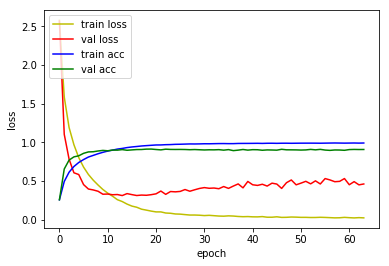

4815/4815 [==============================] - 2s 321us/sample - loss: 0.4305 - acc: 0.8744
Loss: 0.43045430901389753 Accuracy: 0.87435097

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.7842 - acc: 0.4785
Epoch 00001: val_loss improved from inf to 3.20884, saving model to model/checkpoint/1D_CNN_BN_4_conv_1_fcn_checkpoint/01-3.2088.hdf5
36805/36805 [==============================] - 23s 633us/sample - loss: 1.7831 - acc: 0.4787 - val_loss: 3.2088 - val_acc: 0.2833
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.9009 - acc: 0.7189
Epoch 00002: val_loss improved from 3.20884 to 0.56908, saving model to model/checkpoint/1D_CNN_BN_4_conv_1_fcn_checkpoint/02-0.5691.hdf5
36805/36805 [==============================] - 16s 423us/sample - loss: 0.9012 - acc: 0.7187 - val_loss: 0.5691 - val_acc: 0.8178
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.6199 - acc: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0204 - acc: 0.9935
Epoch 00027: val_loss did not improve from 0.25003
36805/36805 [==============================] - 15s 414us/sample - loss: 0.0204 - acc: 0.9935 - val_loss: 0.2811 - val_acc: 0.9304
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9931
Epoch 00028: val_loss did not improve from 0.25003
36805/36805 [==============================] - 16s 428us/sample - loss: 0.0221 - acc: 0.9930 - val_loss: 0.3394 - val_acc: 0.9224
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9916
Epoch 00029: val_loss did not improve from 0.25003
36805/36805 [==============================] - 16s 423us/sample - loss: 0.0264 - acc: 0.9916 - val_loss: 0.3044 - val_acc: 0.9264
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9927
Epoch 00030: val_loss did not improve from 0.25003
36805/36805 [==================

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9963
Epoch 00057: val_loss did not improve from 0.25003
36805/36805 [==============================] - 16s 421us/sample - loss: 0.0114 - acc: 0.9963 - val_loss: 0.3311 - val_acc: 0.9320
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9968
Epoch 00058: val_loss did not improve from 0.25003
36805/36805 [==============================] - 16s 425us/sample - loss: 0.0098 - acc: 0.9968 - val_loss: 0.3281 - val_acc: 0.9329
Epoch 59/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9970
Epoch 00059: val_loss did not improve from 0.25003
36805/36805 [==============================] - 15s 419us/sample - loss: 0.0102 - acc: 0.9970 - val_loss: 0.3566 - val_acc: 0.9306
Epoch 60/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.9967
Epoch 00060: val_loss did not improve from 0.25003
36805/36805 [=====

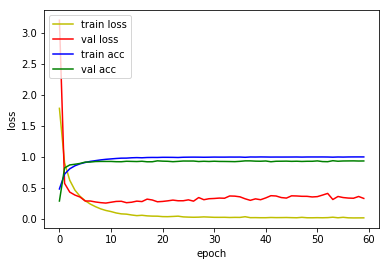

4815/4815 [==============================] - 2s 366us/sample - loss: 0.3521 - acc: 0.8970
Loss: 0.352114003841008 Accuracy: 0.8969886

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.2920 - acc: 0.3239
Epoch 00001: val_loss improved from inf to 4.01272, saving model to model/checkpoint/1D_CNN_BN_4_conv_2_fcn_checkpoint/01-4.0127.hdf5
36805/36805 [==============================] - 26s 712us/sample - loss: 2.2919 - acc: 0.3239 - val_loss: 4.0127 - val_acc: 0.1593
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.3384 - acc: 0.5718
Epoch 00002: val_loss improved from 4.01272 to 0.79505, saving model to model/checkpoint/1D_CNN_BN_4_conv_2_fcn_checkpoint/02-0.7951.hdf5
36805/36805 [==============================] - 16s 436us/sample - loss: 1.3383 - acc: 0.5718 - val_loss: 0.7951 - val_acc: 0.7517
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9567 - acc: 0.6

Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9817
Epoch 00027: val_loss did not improve from 0.22317
36805/36805 [==============================] - 16s 430us/sample - loss: 0.0556 - acc: 0.9817 - val_loss: 0.2865 - val_acc: 0.9336
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0534 - acc: 0.9831
Epoch 00028: val_loss did not improve from 0.22317
36805/36805 [==============================] - 16s 432us/sample - loss: 0.0535 - acc: 0.9831 - val_loss: 0.2847 - val_acc: 0.9341
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0504 - acc: 0.9837
Epoch 00029: val_loss did not improve from 0.22317
36805/36805 [==============================] - 16s 432us/sample - loss: 0.0504 - acc: 0.9838 - val_loss: 0.2935 - val_acc: 0.9334
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9835
Epoch 00030: val_loss did not improve from 0.22317
36805/36805 [=====

Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9937
Epoch 00057: val_loss did not improve from 0.22317
36805/36805 [==============================] - 16s 435us/sample - loss: 0.0192 - acc: 0.9937 - val_loss: 0.3786 - val_acc: 0.9292
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9940
Epoch 00058: val_loss did not improve from 0.22317
36805/36805 [==============================] - 16s 436us/sample - loss: 0.0194 - acc: 0.9939 - val_loss: 0.3899 - val_acc: 0.9285
Epoch 59/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9915
Epoch 00059: val_loss did not improve from 0.22317
36805/36805 [==============================] - 16s 439us/sample - loss: 0.0270 - acc: 0.9916 - val_loss: 0.3934 - val_acc: 0.9338
Epoch 60/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9932
Epoch 00060: val_loss did not improve from 0.22317
36805/36805 [=====

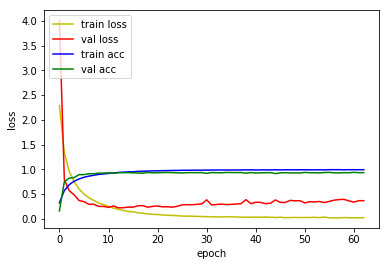

4815/4815 [==============================] - 2s 353us/sample - loss: 0.3127 - acc: 0.9061
Loss: 0.3126608382751885 Accuracy: 0.9061267

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.8503 - acc: 0.4303
Epoch 00001: val_loss improved from inf to 2.04586, saving model to model/checkpoint/1D_CNN_BN_5_conv_1_fcn_checkpoint/01-2.0459.hdf5
36805/36805 [==============================] - 29s 788us/sample - loss: 1.8505 - acc: 0.4302 - val_loss: 2.0459 - val_acc: 0.3927
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0346 - acc: 0.6669
Epoch 00002: val_loss improved from 2.04586 to 0.90224, saving model to model/checkpoint/1D_CNN_BN_5_conv_1_fcn_checkpoint/02-0.9022.hdf5
36805/36805 [==============================] - 17s 464us/sample - loss: 1.0347 - acc: 0.6668 - val_loss: 0.9022 - val_acc: 0.7100
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.7227 - acc: 0.

Epoch 26/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9873
Epoch 00026: val_loss did not improve from 0.22617
36805/36805 [==============================] - 17s 460us/sample - loss: 0.0401 - acc: 0.9873 - val_loss: 0.2359 - val_acc: 0.9397
Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9913
Epoch 00027: val_loss did not improve from 0.22617
36805/36805 [==============================] - 17s 461us/sample - loss: 0.0273 - acc: 0.9913 - val_loss: 0.2752 - val_acc: 0.9338
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9907
Epoch 00028: val_loss did not improve from 0.22617
36805/36805 [==============================] - 17s 452us/sample - loss: 0.0280 - acc: 0.9907 - val_loss: 0.2633 - val_acc: 0.9373
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9921
Epoch 00029: val_loss did not improve from 0.22617
36805/36805 [=====

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9939
Epoch 00056: val_loss did not improve from 0.22617
36805/36805 [==============================] - 18s 479us/sample - loss: 0.0194 - acc: 0.9939 - val_loss: 0.2770 - val_acc: 0.9422
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9966
Epoch 00057: val_loss did not improve from 0.22617
36805/36805 [==============================] - 17s 475us/sample - loss: 0.0109 - acc: 0.9966 - val_loss: 0.2878 - val_acc: 0.9392
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9961
Epoch 00058: val_loss did not improve from 0.22617
36805/36805 [==============================] - 17s 468us/sample - loss: 0.0114 - acc: 0.9961 - val_loss: 0.2955 - val_acc: 0.9399
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9957
Epoch 00059: val_loss did not improve from 0.22617
36805/36805 [=====

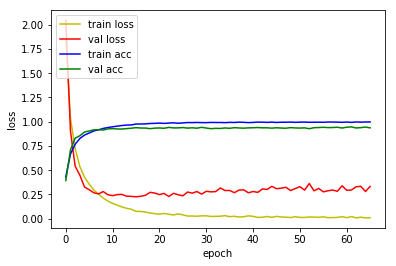

4815/4815 [==============================] - 2s 400us/sample - loss: 0.3130 - acc: 0.9169
Loss: 0.31300048009876397 Accuracy: 0.91692626

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.1049 - acc: 0.3543
Epoch 00001: val_loss improved from inf to 1.47616, saving model to model/checkpoint/1D_CNN_BN_5_conv_2_fcn_checkpoint/01-1.4762.hdf5
36805/36805 [==============================] - 32s 868us/sample - loss: 2.1050 - acc: 0.3543 - val_loss: 1.4762 - val_acc: 0.5213
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.1866 - acc: 0.6161
Epoch 00002: val_loss improved from 1.47616 to 0.83808, saving model to model/checkpoint/1D_CNN_BN_5_conv_2_fcn_checkpoint/02-0.8381.hdf5
36805/36805 [==============================] - 16s 442us/sample - loss: 1.1866 - acc: 0.6161 - val_loss: 0.8381 - val_acc: 0.7265
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.8258 - acc: 

Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0663 - acc: 0.9787
Epoch 00026: val_loss did not improve from 0.18529
36805/36805 [==============================] - 16s 442us/sample - loss: 0.0665 - acc: 0.9786 - val_loss: 0.2336 - val_acc: 0.9436
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0728 - acc: 0.9757
Epoch 00027: val_loss did not improve from 0.18529
36805/36805 [==============================] - 16s 441us/sample - loss: 0.0728 - acc: 0.9756 - val_loss: 0.2332 - val_acc: 0.9460
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0610 - acc: 0.9798
Epoch 00028: val_loss did not improve from 0.18529
36805/36805 [==============================] - 16s 443us/sample - loss: 0.0609 - acc: 0.9799 - val_loss: 0.2426 - val_acc: 0.9380
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0531 - acc: 0.9826
Epoch 00029: val_loss did not improve from 0.18529
36805/36805 [=====

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9915
Epoch 00056: val_loss did not improve from 0.18529
36805/36805 [==============================] - 16s 441us/sample - loss: 0.0263 - acc: 0.9915 - val_loss: 0.3103 - val_acc: 0.9415
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9922
Epoch 00057: val_loss did not improve from 0.18529
36805/36805 [==============================] - 16s 441us/sample - loss: 0.0245 - acc: 0.9922 - val_loss: 0.3146 - val_acc: 0.9439
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9918
Epoch 00058: val_loss did not improve from 0.18529
36805/36805 [==============================] - 16s 439us/sample - loss: 0.0254 - acc: 0.9918 - val_loss: 0.3583 - val_acc: 0.9331
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9940
Epoch 00059: val_loss did not improve from 0.18529
36805/36805 [=====

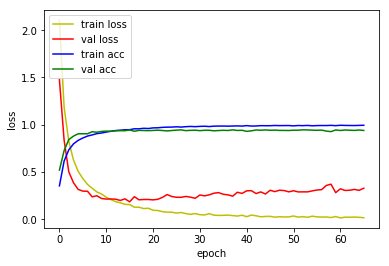

4815/4815 [==============================] - 2s 426us/sample - loss: 0.2654 - acc: 0.9240
Loss: 0.2653847798999101 Accuracy: 0.92398757



In [11]:
for i in range(1, 6):
    for j in range(1, 3):
        model = build_batchnorm_cnn(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/1D_CNN_BN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])
        print()
        print('{} Conv {} FCN Model'.format(i, j))
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()

        png_path = 'visualization/learning_curve/'
        filename = '1D_CNN_BN_{}_conv_{}_fcn'.format(i, j)+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)

        del(model)
        
        model_path = 'model/checkpoint/1D_CNN_BN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)# os.environ['CUDA_VISIBLE_DEVICES'] = ''
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [12]:
for i in range(1, 6):
    for j in range(1, 3):
        print()
        print('{} Conv {} FCN Model'.format(i, j))
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/1D_CNN_BN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        
        del(model)


1 Conv 1 FCN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15976, 8)          32        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3994, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 31952)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              32719872  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1

4815/4815 [==============================] - 2s 396us/sample - loss: 0.5191 - acc: 0.8461
Loss: 0.5190651477682999 Accuracy: 0.84610593

3 Conv 2 FCN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 15976, 8)          32        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 3994, 8)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 3970, 16)          3216      
_________________________________________________________________
batch_normalization_v1_10 (B (None, 3970, 16)          64        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 993, 16)        

4815/4815 [==============================] - 3s 546us/sample - loss: 0.3130 - acc: 0.9169
Loss: 0.31300048009876397 Accuracy: 0.91692626

5 Conv 2 FCN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_25 (B (None, 15976, 8)          32        
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 3970, 16)          3216      
_________________________________________________________________
batch_normalization_v1_26 (B (None, 3970, 16)          64        
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 993, 16)       